<a href="https://colab.research.google.com/github/Kryptera-K/PSKY-Ichimoku-QQE-Momentum-Reversal-Strategy/blob/main/PSKY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "PSKY"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("PSKY_clean.csv", index=False)
df

/tmp/ipython-input-3243814386.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2005-12-05,16.964727,19.061491,16.964727,19.061491,1087800
2005-12-06,16.367466,17.060034,16.361112,17.060034,1743800
2005-12-07,16.234030,16.519953,16.043415,16.519953,1536400
2005-12-08,16.132374,16.361112,15.948113,16.221328,2100700
2005-12-09,16.284861,16.488184,15.852801,16.138723,2414700
...,...,...,...,...,...
2025-10-20,16.990000,17.090000,16.650000,16.930000,2422000
2025-10-21,16.510000,17.290001,16.450001,17.150000,4350700
2025-10-22,16.570000,16.730000,16.280001,16.469999,2655200


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

EMA_PERIOD = 20
EMA_SHIFT = 5
ICHIMOKU_DISPLACEMENT = 26
ICHIMOKU_KIJUN_PERIOD = 26
ICHIMOKU_SENKOU_B_PERIOD = 52
ICHIMOKU_TENKAN_PERIOD = 9
QQE_FACTOR = 4.236
QQE_LEVEL = 50
QQE_PERIOD = 14
QQE_SHIFT = 5
QQE_SMOOTH = 5
CONNORS_RSI_PERIOD = 3
CONNORS_RSI_STREAK_PERIOD = 2
CONNORS_RSI_RANK_PERIOD = 100
CONNORS_RSI_LEVEL = 50
CONNORS_RSI_OVERBOUGHT = 70
CONNORS_RSI_OVERSOLD = 30

# -------------------------
# Indicator Functions
# -------------------------

def price_cross_kijun_bearish(df):
    df = calculate_ichimoku(df)
    return (df['Close'].shift(1) > df['kijun_sen'].shift(1)) & (df['Close'] < df['kijun_sen'])


def calculate_ichimoku(df, tenkan_period=ICHIMOKU_TENKAN_PERIOD, kijun_period=ICHIMOKU_KIJUN_PERIOD, senkou_b_period=ICHIMOKU_SENKOU_B_PERIOD, displacement=ICHIMOKU_DISPLACEMENT):
    df = df.copy()

    # Lines
    df['tenkan_sen'] = (df['High'].rolling(tenkan_period).max() + df['Low'].rolling(tenkan_period).min()) / 2
    df['kijun_sen'] = (df['High'].rolling(kijun_period).max() + df['Low'].rolling(kijun_period).min()) / 2
    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(displacement)
    df['senkou_span_b'] = ((df['High'].rolling(senkou_b_period).max() + df['Low'].rolling(senkou_b_period).min()) / 2).shift(displacement)
    df['chikou_span'] = df['Close'].shift(-displacement)

    return df


def qqe_value1_higher_than_level(df, level=QQE_LEVEL):
    df = calculate_qqe(df)
    return df['QQE_Value1'] > level


def calculate_qqe(df, rsi_period=QQE_PERIOD, smooth=QQE_SMOOTH, factor=QQE_FACTOR):
    """
    Calculate QQE lines (Value1 & Value2) based on RSI smoothing and ATR-like smoothing.
    """
    df = df.copy()

    # --- RSI ---
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(alpha=1/rsi_period, adjust=False).mean()
    roll_down = down.ewm(alpha=1/rsi_period, adjust=False).mean()
    rsi = 100 - (100 / (1 + roll_up / roll_down))

    # --- Smoothed RSI ---
    rsi_ma = rsi.rolling(window=smooth).mean().fillna(method='bfill')

    # --- RSI Delta & ATR-like smoothing ---
    rsi_delta = rsi_ma.diff().abs().fillna(0)
    atr_rsi = rsi_delta.ewm(alpha=1/smooth, adjust=False).mean()

    # --- QQE Calculation ---
    value1 = rsi_ma.copy()
    value2 = pd.Series(index=df.index, dtype=float)
    value2.iloc[0] = value1.iloc[0]

    for i in range(1, len(df)):
        prev_trail = value2.iloc[i-1]
        prev_value1 = value1.iloc[i-1]
        atr = atr_rsi.iloc[i]
        direction = 1 if prev_value1 > prev_trail else -1
        value2.iloc[i] = prev_trail + direction * factor * atr

    df['QQE_Value1'] = value1
    df['QQE_Value2'] = value2

    return df


def crsi_cross_above_overbought(df, level=CONNORS_RSI_OVERBOUGHT):
    df = connors_rsi(df)
    return (df['ConnorsRSI'] > level) & (df['ConnorsRSI'].shift(1) <= level)


def connors_rsi(df, rsi_period=CONNORS_RSI_PERIOD, streak_rsi_period=CONNORS_RSI_STREAK_PERIOD, rank_period=CONNORS_RSI_RANK_PERIOD):
    df = df.copy()

    # 1. Classic RSI
    delta = df['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(rsi_period).mean()
    avg_loss = loss.rolling(rsi_period).mean()
    rsi = 100 - (100 / (1 + (avg_gain / avg_loss + 1e-9)))  # avoid divide by zero

    # 2. Streak RSI
    sign_diff = np.sign(delta)
    streak = sign_diff.groupby((sign_diff != sign_diff.shift()).cumsum()).cumsum()
    streak_rsi = streak.rolling(streak_rsi_period).apply(
        lambda x: 100 - (100 / (1 + (x.clip(lower=0).sum() / (-x.clip(upper=0).sum() + 1e-9))))
    )

    # 3. Percent Rank
    roc = df['Close'].pct_change()
    rank = roc.rolling(rank_period).apply(lambda x: x.rank().iloc[-1] / len(x) * 100, raw=False)

    # Combine
    df['ConnorsRSI'] = (rsi + streak_rsi + rank) / 3
    return df


def close_below_ema(df, period=EMA_PERIOD):
    df = calculate_ema(df, period)
    return df['Close'] < df['EMA']


def calculate_ema(df, period=EMA_PERIOD):
    """
    Calculate Exponential Moving Average (EMA) of the Close price.
    """
    df = df.copy()
    df['EMA'] = df['Close'].ewm(span=period, adjust=False).mean()
    return df



# -------------------------
# Entry conditions
# -------------------------

df["Ichimoku_Price_Cross_Kijun_Bearish"] = price_cross_kijun_bearish(df)
df["QQE_Value1_HigherThan_Level"] = qqe_value1_higher_than_level(df)

# -------------------------
# Exit conditions
# -------------------------

df["CRSI_Cross_Above_Overbought"] = crsi_cross_above_overbought(df)
df["EMA_Close_Below"] = close_below_ema(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'Ichimoku_Price_Cross_Kijun_Bearish',
    'QQE_Value1_HigherThan_Level',
]
exit_conditions = [
    'CRSI_Cross_Above_Overbought',
    'EMA_Close_Below',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

/tmp/ipython-input-1475608787.py:65: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rsi_ma = rsi.rolling(window=smooth).mean().fillna(method='bfill')


Start                                2005-12-05 00:00:00
End                                  2025-10-24 00:00:00
Period                                5004 days 00:00:00
Start Value                                     100000.0
End Value                                  767760.316677
Total Return [%]                              667.760317
Benchmark Return [%]                          -12.441264
Max Gross Exposure [%]                             100.0
Total Fees Paid                             38942.302336
Max Drawdown [%]                                68.24664
Max Drawdown Duration                 1155 days 00:00:00
Total Trades                                          65
Total Closed Trades                                   65
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                   41.538462
Best Trade [%]                                 88.994575
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2005-12-05 00:00:00
End                           2025-10-24 00:00:00
Period                         5004 days 00:00:00
Start Value                              100000.0
End Value                            87558.736124
Total Return [%]                       -12.441264
Benchmark Return [%]                   -12.441264
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        89.791706
Max Drawdown Duration          1155 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                      -12441.263876
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-703928533.py:15: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-703928533.py:58: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



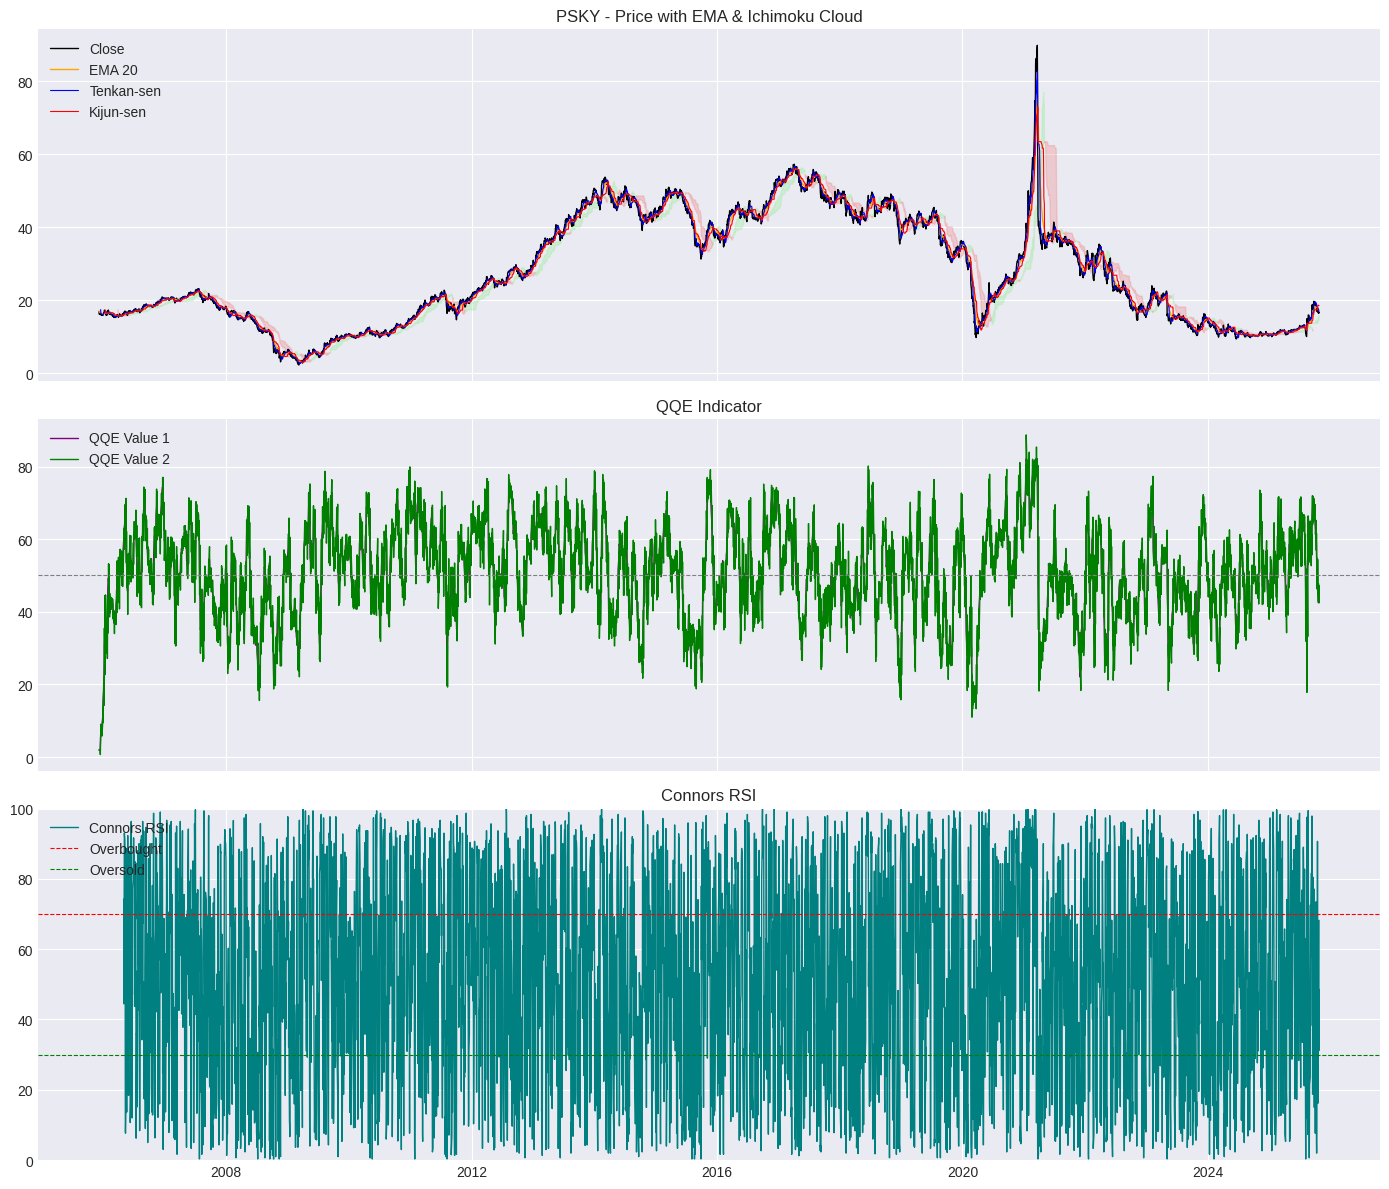

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------------
# Download Data
# -------------------------

symbol = "PSKY"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)

# -------------------------
# Parameters
# -------------------------

EMA_PERIOD = 20
ICHIMOKU_TENKAN_PERIOD = 9
ICHIMOKU_KIJUN_PERIOD = 26
ICHIMOKU_SENKOU_B_PERIOD = 52
ICHIMOKU_DISPLACEMENT = 26

QQE_PERIOD = 14
QQE_SMOOTH = 5
QQE_FACTOR = 4.236

CONNORS_RSI_PERIOD = 3
CONNORS_RSI_STREAK_PERIOD = 2
CONNORS_RSI_RANK_PERIOD = 100

# -------------------------
# Indicator Calculations
# -------------------------

def calculate_ema(df, period=EMA_PERIOD):
    df['EMA'] = df['Close'].ewm(span=period, adjust=False).mean()
    return df

def calculate_ichimoku(df, tenkan_period, kijun_period, senkou_b_period, displacement):
    df['tenkan_sen'] = (df['High'].rolling(tenkan_period).max() + df['Low'].rolling(tenkan_period).min()) / 2
    df['kijun_sen'] = (df['High'].rolling(kijun_period).max() + df['Low'].rolling(kijun_period).min()) / 2
    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(displacement)
    df['senkou_span_b'] = ((df['High'].rolling(senkou_b_period).max() + df['Low'].rolling(senkou_b_period).min()) / 2).shift(displacement)
    df['chikou_span'] = df['Close'].shift(-displacement)
    return df

def calculate_qqe(df, rsi_period=QQE_PERIOD, smooth=QQE_SMOOTH, factor=QQE_FACTOR):
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(alpha=1/rsi_period, adjust=False).mean()
    roll_down = down.ewm(alpha=1/rsi_period, adjust=False).mean()
    rsi = 100 - (100 / (1 + roll_up / roll_down))
    rsi_ma = rsi.rolling(window=smooth).mean().fillna(method='bfill')
    rsi_delta = rsi_ma.diff().abs().fillna(0)
    atr_rsi = rsi_delta.ewm(alpha=1/smooth, adjust=False).mean()

    value1 = rsi_ma.copy()
    value2 = pd.Series(index=df.index, dtype=float)
    value2.iloc[0] = value1.iloc[0]

    for i in range(1, len(df)):
        prev_trail = value2.iloc[i-1]
        prev_value1 = value1.iloc[i-1]
        atr = atr_rsi.iloc[i]
        direction = 1 if prev_value1 > prev_trail else -1
        value2.iloc[i] = prev_trail + direction * factor * atr

    df['QQE_Value1'] = value1
    df['QQE_Value2'] = value2
    return df

def connors_rsi(df, rsi_period=CONNORS_RSI_PERIOD, streak_rsi_period=CONNORS_RSI_STREAK_PERIOD, rank_period=CONNORS_RSI_RANK_PERIOD):
    delta = df['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(rsi_period).mean()
    avg_loss = loss.rolling(rsi_period).mean()
    rsi = 100 - (100 / (1 + (avg_gain / (avg_loss + 1e-9))))

    sign_diff = np.sign(delta)
    streak = sign_diff.groupby((sign_diff != sign_diff.shift()).cumsum()).cumsum()
    streak_rsi = streak.rolling(streak_rsi_period).apply(
        lambda x: 100 - (100 / (1 + (x.clip(lower=0).sum() / (-x.clip(upper=0).sum() + 1e-9)))))

    roc = df['Close'].pct_change()
    rank = roc.rolling(rank_period).apply(lambda x: x.rank().iloc[-1] / len(x) * 100 if len(x.dropna()) > 0 else np.nan)

    df['ConnorsRSI'] = (rsi + streak_rsi + rank) / 3
    return df

# Compute all indicators
df = calculate_ema(df)
df = calculate_ichimoku(df, ICHIMOKU_TENKAN_PERIOD, ICHIMOKU_KIJUN_PERIOD, ICHIMOKU_SENKOU_B_PERIOD, ICHIMOKU_DISPLACEMENT)
df = calculate_qqe(df)
df = connors_rsi(df)

# -------------------------
# Plotting
# -------------------------

plt.style.use('seaborn-v0_8-darkgrid')
fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# --- 1. Price + EMA + Ichimoku ---
axs[0].plot(df.index, df['Close'], label='Close', color='black', linewidth=1)
axs[0].plot(df.index, df['EMA'], label=f'EMA {EMA_PERIOD}', color='orange', linewidth=1)
axs[0].plot(df.index, df['tenkan_sen'], label='Tenkan-sen', color='blue', linewidth=0.8)
axs[0].plot(df.index, df['kijun_sen'], label='Kijun-sen', color='red', linewidth=0.8)
axs[0].fill_between(df.index, df['senkou_span_a'], df['senkou_span_b'],
                    where=df['senkou_span_a'] >= df['senkou_span_b'], color='lightgreen', alpha=0.3)
axs[0].fill_between(df.index, df['senkou_span_a'], df['senkou_span_b'],
                    where=df['senkou_span_a'] < df['senkou_span_b'], color='lightcoral', alpha=0.3)
axs[0].set_title(f"{symbol} - Price with EMA & Ichimoku Cloud")
axs[0].legend(loc="upper left")

# --- 2. QQE Indicator ---
axs[1].plot(df.index, df['QQE_Value1'], label='QQE Value 1', color='purple', linewidth=1)
axs[1].plot(df.index, df['QQE_Value2'], label='QQE Value 2', color='green', linewidth=1)
axs[1].axhline(50, color='gray', linestyle='--', linewidth=0.8)
axs[1].set_title("QQE Indicator")
axs[1].legend(loc="upper left")

# --- 3. Connors RSI ---
axs[2].plot(df.index, df['ConnorsRSI'], label='Connors RSI', color='teal', linewidth=1)
axs[2].axhline(70, color='red', linestyle='--', linewidth=0.8, label='Overbought')
axs[2].axhline(30, color='green', linestyle='--', linewidth=0.8, label='Oversold')
axs[2].set_ylim(0, 100)
axs[2].set_title("Connors RSI")
axs[2].legend(loc="upper left")

plt.tight_layout()
plt.show()
